In [1]:
import numpy as np
import pandas as pd
import akshare as ak
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import easyquotation

## Performance

In [9]:
import numpy as np

def performance_summary(df, ret_col="strategy", bench_col="ret"):
    df = df.dropna(subset=[ret_col])
    # 策略 & 市场累计收益
    cum_strategy = (1 + df[ret_col]).cumprod() - 1
    cum_market   = (1 + df[bench_col]).cumprod() - 1

    # 年化收益 (252交易日假定)
    annual_ret_s = (1 + cum_strategy.iloc[-1]) ** (252/len(df)) - 1
    annual_ret_m = (1 + cum_market.iloc[-1]) ** (252/len(df)) - 1

    # 年化波动 & 夏普比率（假定无风险利率=0）
    vol_s = df[ret_col].std() * np.sqrt(252)
    sharpe_s = annual_ret_s / vol_s if vol_s != 0 else np.nan

    # 最大回撤
    roll_max = (1 + df[ret_col]).cumprod().cummax()
    dd = (1 + df[ret_col]).cumprod()/roll_max - 1
    max_dd = dd.min()

    # 胜率
    win_rate = (df[ret_col] > 0).mean()

    return {
        "累计收益": cum_strategy.iloc[-1],
        "年化收益": annual_ret_s,
        "最大回撤": max_dd,
        "夏普比率": sharpe_s,
        "胜率": win_rate,
        "市场年化": annual_ret_m
    }

# 3 Ver


📊 Version 1 - 单周期MACD绩效
累计收益: 133.79%
年化收益: 6.76%
最大回撤: -34.91%
夏普比率: 37.89%
胜率: 24.10%
市场年化: 7.46%


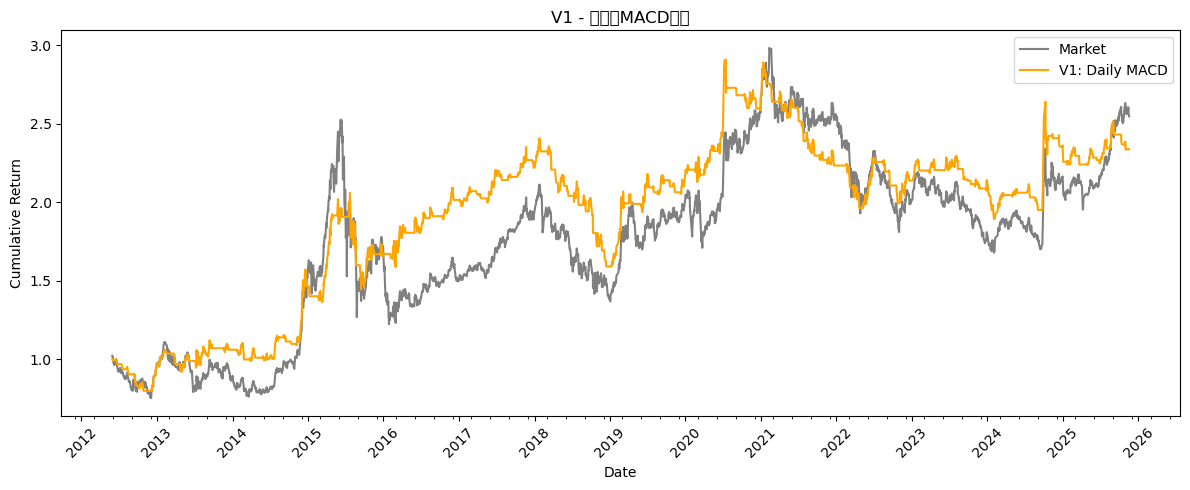


📊 Version 2 - 多周期共振绩效
累计收益: 82.68%
年化收益: 4.75%
最大回撤: -27.93%
夏普比率: 38.93%
胜率: 11.64%
市场年化: 7.46%


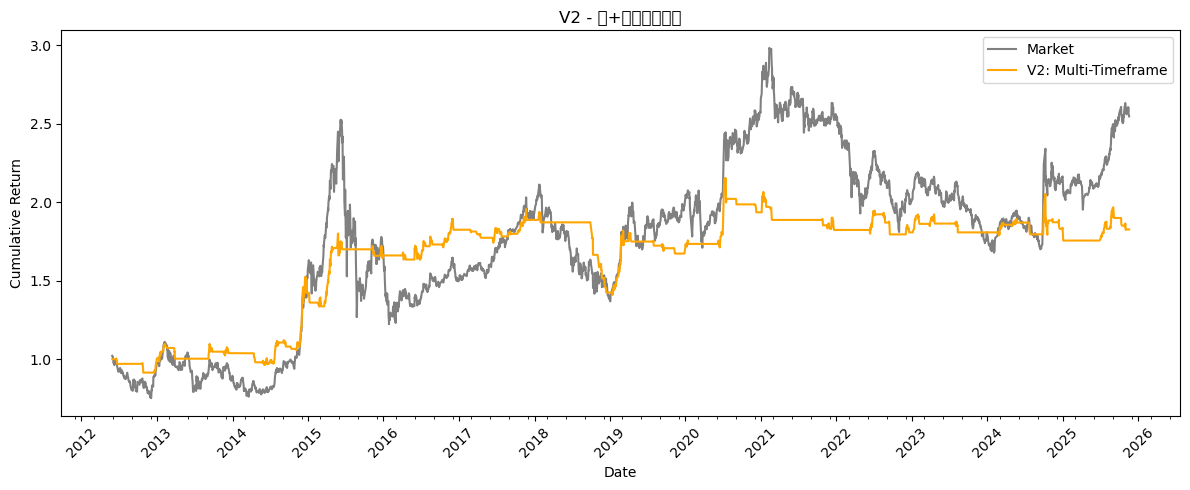


📊 Version 3 - 多周期 + 风控绩效
累计收益: 29.15%
年化收益: 1.99%
最大回撤: -7.67%
夏普比率: 48.18%
胜率: 12.30%
市场年化: 7.54%


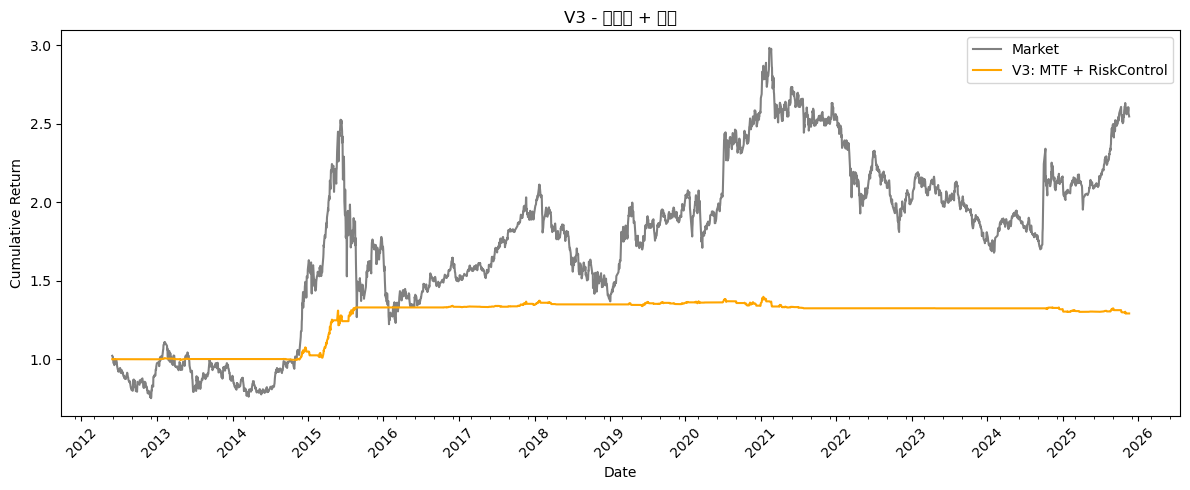


📈 三版本绩效汇总：
       累计收益   年化收益     最大回撤    夏普比率      胜率   市场年化
V1  133.79%  6.76%  -34.91%  37.89%  24.10%  7.46%
V2   82.68%  4.75%  -27.93%  38.93%  11.64%  7.46%
V3   29.15%  1.99%   -7.67%  48.18%  12.30%  7.54%


In [11]:
# =======================================================
# HS300ETF 多周期趋势策略 —— 三版本完整版
# 作者: ChatGPT
# 功能: 单周期策略、多周期共振策略、加止损风险控制策略
# 数据需求: HS300ETF_daily.csv （含日期、OHLC、volume等）
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==================== 公共函数 ====================
def performance_summary(df, ret_col="strategy", bench_col="ret"):
    """计算绩效指标"""
    df = df.dropna(subset=[ret_col])
    cum_strategy = (1 + df[ret_col]).cumprod() - 1
    cum_market = (1 + df[bench_col]).cumprod() - 1

    ann_s = (1 + cum_strategy.iloc[-1]) ** (252 / len(df)) - 1
    ann_m = (1 + cum_market.iloc[-1]) ** (252 / len(df)) - 1

    vol = df[ret_col].std() * np.sqrt(252)
    sharpe = ann_s / vol if vol != 0 else np.nan

    roll_max = (1 + df[ret_col]).cumprod().cummax()
    dd = (1 + df[ret_col]).cumprod() / roll_max - 1
    max_dd = dd.min()

    win_rate = (df[ret_col] > 0).mean()

    return {
        "累计收益": cum_strategy.iloc[-1],
        "年化收益": ann_s,
        "最大回撤": max_dd,
        "夏普比率": sharpe,
        "胜率": win_rate,
        "市场年化": ann_m
    }

def plot_equity(df, strategy_label, title):
    """收益曲线图，带日期格式化"""
    plt.figure(figsize=(12,5))
    plt.plot(df["date"], (1 + df["ret"]).cumprod(), label="Market", color="gray")
    plt.plot(df["date"], (1 + df["strategy"]).cumprod(), label=strategy_label, color="orange")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==================== 数据载入 ====================
df = pd.read_csv("HS300ETF_daily.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# ==================== Version 1 - 单周期 MACD ====================
short, long, sig = 12, 26, 9
df["ema_fast"] = df["close"].ewm(span=short).mean()
df["ema_slow"] = df["close"].ewm(span=long).mean()
df["dif"] = df["ema_fast"] - df["ema_slow"]
df["dea"] = df["dif"].ewm(span=sig).mean()
df["macd"] = 2 * (df["dif"] - df["dea"])
df["signal"] = (df["macd"] > 0).astype(int)
df["ret"] = df["close"].pct_change()
df["strategy"] = df["signal"].shift(1) * df["ret"]

perf1 = performance_summary(df)
print("\n📊 Version 1 - 单周期MACD绩效")
for k,v in perf1.items(): print(f"{k}: {v:,.2%}")
plot_equity(df, "V1: Daily MACD", "V1 - 单周期MACD策略")

# ==================== Version 2 - 多周期共振(日+周) ====================
df2 = df.copy()
df_week = df2.resample("W-FRI", on="date").agg({
    "open":"first","high":"max","low":"min","close":"last"}).dropna().reset_index()

df2["ema_f"]=df2["close"].ewm(span=12).mean()
df2["ema_s"]=df2["close"].ewm(span=26).mean()
df2["dif"]=df2["ema_f"]-df2["ema_s"]
df2["dea"]=df2["dif"].ewm(span=9).mean()
df2["macd"]=2*(df2["dif"]-df2["dea"])

df_week["ema_f"]=df_week["close"].ewm(span=12).mean()
df_week["ema_s"]=df_week["close"].ewm(span=26).mean()
df_week["dif"]=df_week["ema_f"]-df_week["ema_s"]
df_week["dea"]=df_week["dif"].ewm(span=9).mean()
df_week["macd_w"]=2*(df_week["dif"]-df_week["dea"])

df2["trend_w"]=df2["date"].map(
    lambda d: df_week.loc[df_week["date"]<=d,"macd_w"].iloc[-1] if any(df_week["date"]<=d) else None
)
df2["signal"]=((df2["macd"]>0)&(df2["trend_w"]>0)).astype(int)
df2["strategy"]=df2["signal"].shift(1)*df2["ret"]

perf2=performance_summary(df2)
print("\n📊 Version 2 - 多周期共振绩效")
for k,v in perf2.items(): print(f"{k}: {v:,.2%}")
plot_equity(df2, "V2: Multi-Timeframe", "V2 - 日+周多周期共振")

# ==================== Version 3 - 多周期 + 风控 ====================
df3 = df.copy()
dfw = df3.resample("W-FRI", on="date")["close"].last().dropna().to_frame()
dfw["macd"]=dfw["close"].ewm(span=12).mean()-dfw["close"].ewm(span=26).mean()
dfw["strength"]=dfw["macd"].rolling(3).mean()
df3["trend_str"]=df3["date"].map(
    lambda d: dfw.loc[dfw.index<=d,"strength"].iloc[-1] if any(dfw.index<=d) else 0
)

df3["ema_f"]=df3["close"].ewm(span=12).mean()
df3["ema_s"]=df3["close"].ewm(span=26).mean()
df3["dif"]=df3["ema_f"]-df3["ema_s"]
df3["dea"]=df3["dif"].ewm(span=9).mean()
df3["macd"]=2*(df3["dif"]-df3["dea"])
df3["signal"]=(df3["macd"]>0).astype(int)
df3["pos"]=np.clip(df3["trend_str"]/abs(df3["trend_str"]).max(),0,1)*df3["signal"].shift(1)
df3["ret"]=df3["close"].pct_change()

# 止损模块
stop=0.05
df3["entry"]=np.where(df3["signal"].diff()==1,df3["close"],np.nan)
df3["entry"]=df3["entry"].ffill()
df3["dd"]=(df3["close"]-df3["entry"])/df3["entry"]
df3.loc[df3["dd"]<-stop,"pos"]=0

df3["strategy"]=df3["pos"]*df3["ret"]

perf3=performance_summary(df3)
print("\n📊 Version 3 - 多周期 + 风控绩效")
for k,v in perf3.items(): print(f"{k}: {v:,.2%}")
plot_equity(df3, "V3: MTF + RiskControl", "V3 - 多周期 + 风控")

# =======================================================
# 输出对比汇总
# =======================================================
summary = pd.DataFrame([perf1, perf2, perf3], index=["V1","V2","V3"])
print("\n📈 三版本绩效汇总：")
print(summary.applymap(lambda x: f"{x:,.2%}"))